Bevi Data Science Co-op Forecasting Exercise
The goal of this exercise is to understand your approach to building an ML model in Python. The following are the aspects that we will be looking at.
- Data Handling and assumptions
- Feature Engineering
- Model Selection
- Accuracy Checks
- Inferences
- Next Steps

Exercise:
- We’ve given you weekly dispense data for six of our machines before October 2023. You need to use this data to create a forecasted weekly total usage for the weeks in months July to November.

- Your forecasts should be based on data till the end of June 2023. The data provided for July 23 to September 23 is only for testing purposes.
Week: 
- Our week starts on Monday and ends on Sunday. The weekend dates you see in the data represent the date a week ended with.

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA


In [2]:
# loading dataset
data = pd.read_excel('co-op dataset.xlsx')

In [3]:
# checking for missing values
missing_values = data.isna().sum()
print(missing_values)

ID                     0
WEEK_END_DT            0
TOTAL_DISPENSED       43
FLAVORED_DISPENSED    43
dtype: int64


In [5]:
data.head()

,ID,WEEK_END_DT,TOTAL_DISPENSED,FLAVORED_DISPENSED
0,743BD6E,2022-07-10,278418.0,60878.00000
1,1CD19D3,2022-07-10,28045.0,10517.00004
2,D3635AD,2022-07-10,23631.0,16203.99998
3,A74A256,2022-07-10,NaN,NaN
4,BB7EA2A,2022-07-10,132980.0,79995.00001


Now, let's sort this dataset based on Machine ID's

In [4]:
# Define a custom sorting function
def sort_by_week_end_dt(group):
    return group.sort_values(by='WEEK_END_DT')

# Sort the data by 'ID' and then apply the custom sorting function to each group
data_sorted = data.groupby('ID').apply(sort_by_week_end_dt)

# Print the sorted data
print(data_sorted)


                  ID WEEK_END_DT  TOTAL_DISPENSED  FLAVORED_DISPENSED
ID                                                                   
1CD19D3 1    1CD19D3  2022-07-10          28045.0         10517.00004
        6    1CD19D3  2022-07-17          34723.0         12025.99998
        11   1CD19D3  2022-07-24          33345.0         13743.00000
        16   1CD19D3  2022-07-31          41009.0         17136.00000
        21   1CD19D3  2022-08-07          24561.0          6542.99999
...              ...         ...              ...                 ...
FBCE7D2 326  FBCE7D2  2023-09-03          19166.0          3515.00001
        332  FBCE7D2  2023-09-10          12876.0          5238.00001
        338  FBCE7D2  2023-09-17          19485.0          7958.00000
        344  FBCE7D2  2023-09-24          21427.0          7323.99999
        350  FBCE7D2  2023-10-01          18096.0          6573.00001

[355 rows x 4 columns]


In [7]:
# Check for total values in each ID
id_counts = data['ID'].value_counts()
print(id_counts)

ID
743BD6E    65
1CD19D3    65
D3635AD    65
A74A256    65
BB7EA2A    65
FBCE7D2    30
Name: count, dtype: int64


In [8]:
na_counts = data.groupby('ID').apply(lambda x: x.isna().sum())
print(na_counts)

         ID  WEEK_END_DT  TOTAL_DISPENSED  FLAVORED_DISPENSED
ID                                                           
1CD19D3   0            0               34                  34
743BD6E   0            0                5                   5
A74A256   0            0                4                   4
BB7EA2A   0            0                0                   0
D3635AD   0            0                0                   0
FBCE7D2   0            0                0                   0


Based on the 6 machines 3 have missing values so we will try to find how the data distribution is there in the three machines with missing values.

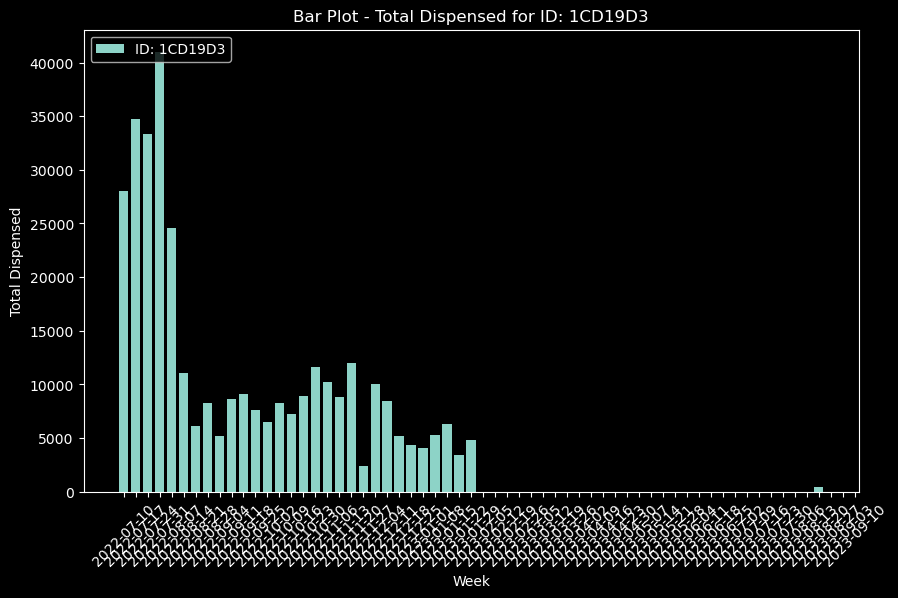

In [9]:
# Filter data for each ID
id_1_data = data[data['ID'] == '1CD19D3']
id_2_data = data[data['ID'] == '743BD6E']
id_3_data = data[data['ID'] == 'A74A256']

# Bar plot
plt.figure(figsize=(10, 6))
plt.bar(id_1_data['WEEK_END_DT'], id_1_data['TOTAL_DISPENSED'], label='ID: 1CD19D3')
plt.xlabel('Week')
plt.ylabel('Total Dispensed')
plt.title('Bar Plot - Total Dispensed for ID: 1CD19D3')
plt.legend()
plt.xticks(rotation=45)
plt.show()


This Machine has almost half missing values, probably this machine is not being used. But still this machine's data needs to be handled

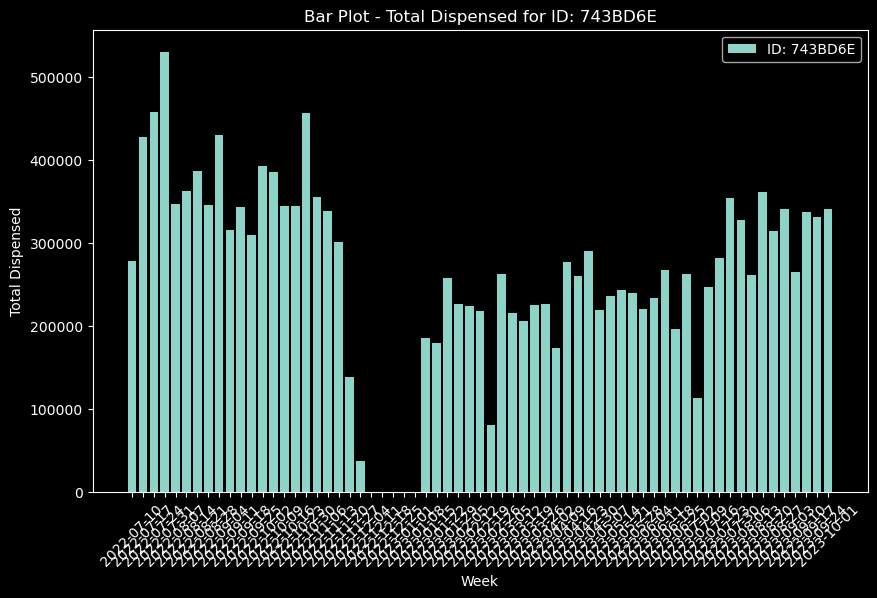

In [ ]:
# Bar plot
plt.figure(figsize=(10, 6))
plt.bar(id_2_data['WEEK_END_DT'], id_2_data['TOTAL_DISPENSED'], label='ID: 743BD6E')
plt.xlabel('Week')
plt.ylabel('Total Dispensed')
plt.title('Bar Plot - Total Dispensed for ID: 743BD6E')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In the above plot few points are missing in the middle, we will handle that as well.

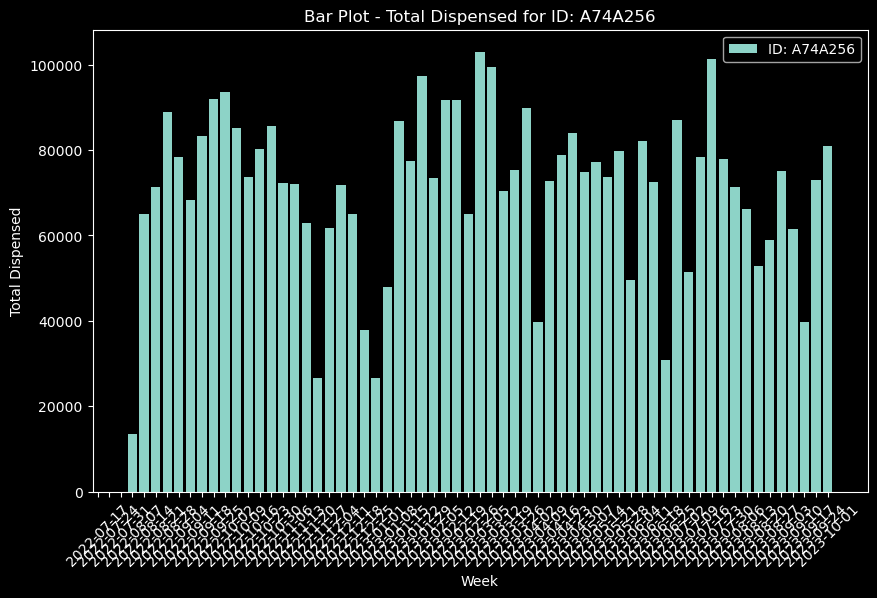

In [11]:
# Bar plot
plt.figure(figsize=(10, 6))
plt.bar(id_3_data['WEEK_END_DT'], id_3_data['TOTAL_DISPENSED'], label='ID: A74A256')
plt.xlabel('Week')
plt.ylabel('Total Dispensed')
plt.title('Bar Plot - Total Dispensed for ID: A74A256')
plt.legend()
plt.xticks(rotation=45)
plt.show()

This machine has few missing values in the start and in the end so we will do some interpolation.

Based on the 6 machines, 3 have missing values. We will handle missing values by using seasonal interpolation specific to each machine to maintain data integrity and avoid biases.

In [12]:
def seasonal_interpolation(data):
    # Convert 'WEEK_END_DT' column to datetime format
    data['WEEK_END_DT'] = pd.to_datetime(data['WEEK_END_DT'])
    
    # Group the data by 'ID'
    grouped_data = data.groupby('ID')
    
    # Perform seasonal interpolation for each group
    interpolated_data = grouped_data.apply(lambda x: interpolate_seasonal(x))
    
    # Reset the index of the interpolated data
    interpolated_data.reset_index(drop=True, inplace=True)
    
    return interpolated_data

def interpolate_seasonal(group):
    # Replace 0 values with NaN in 'TOTAL_DISPENSED' and 'FLAVORED_DISPENSED' columns
    group[['TOTAL_DISPENSED', 'FLAVORED_DISPENSED']] = group[['TOTAL_DISPENSED', 'FLAVORED_DISPENSED']].replace(0, np.nan)
    
    # Perform linear interpolation to fill NaN values in 'TOTAL_DISPENSED'
    group['TOTAL_DISPENSED'] = group['TOTAL_DISPENSED'].interpolate(method='linear')
    
    # Perform linear interpolation to fill NaN values in 'FLAVORED_DISPENSED'
    group['FLAVORED_DISPENSED'] = group['FLAVORED_DISPENSED'].interpolate(method='linear')
    
    return group

# Call the seasonal_interpolation function
interpolated_data = seasonal_interpolation(data)
data = interpolated_data
print(data)


          ID WEEK_END_DT  TOTAL_DISPENSED  FLAVORED_DISPENSED
0    1CD19D3  2022-07-10          28045.0         10517.00004
1    1CD19D3  2022-07-17          34723.0         12025.99998
2    1CD19D3  2022-07-24          33345.0         13743.00000
3    1CD19D3  2022-07-31          41009.0         17136.00000
4    1CD19D3  2022-08-07          24561.0          6542.99999
..       ...         ...              ...                 ...
350  FBCE7D2  2023-09-03          19166.0          3515.00001
351  FBCE7D2  2023-09-10          12876.0          5238.00001
352  FBCE7D2  2023-09-17          19485.0          7958.00000
353  FBCE7D2  2023-09-24          21427.0          7323.99999
354  FBCE7D2  2023-10-01          18096.0          6573.00001

[355 rows x 4 columns]


In [13]:
data

,ID,WEEK_END_DT,TOTAL_DISPENSED,FLAVORED_DISPENSED
0,1CD19D3,2022-07-10,28045.0,10517.00004
1,1CD19D3,2022-07-17,34723.0,12025.99998
2,1CD19D3,2022-07-24,33345.0,13743.00000
3,1CD19D3,2022-07-31,41009.0,17136.00000
4,1CD19D3,2022-08-07,24561.0,6542.99999
...,...,...,...,...
350,FBCE7D2,2023-09-03,19166.0,3515.00001
351,FBCE7D2,2023-09-10,12876.0,5238.00001
352,FBCE7D2,2023-09-17,19485.0,7958.00000
353,FBCE7D2,2023-09-24,21427.0,7323.99999


We will check if there are any null values in the dataset with respect to the machines

In [14]:
zero_counts = data[data['TOTAL_DISPENSED'] == 0].groupby('ID').size()
distinct_zero_counts = zero_counts[zero_counts > 0].reset_index()
distinct_zero_counts.columns = ['ID', 'TOTAL_DISPENSED_zero_count']

zero_counts = data[data['FLAVORED_DISPENSED'] == 0].groupby('ID').size()
distinct_zero_counts['FLAVORED_DISPENSED_zero_count'] = zero_counts[zero_counts > 0].reset_index()[0]

distinct_zero_counts

,ID,TOTAL_DISPENSED_zero_count,FLAVORED_DISPENSED_zero_count


We use subplots to display the bar and line plots for each machine together, making it easier to compare and understand the data.
- Bar Plot: Shows the total dispensed values for each week.
- Line Plot: Shows the trend of total dispensed values over time.

In [15]:
# Define a custom sorting function
def sort_by_week_end_dt(group):
    return group.sort_values(by='WEEK_END_DT')

# Sort the data by 'ID' and then apply the custom sorting function to each group
data_sorted = data.groupby('ID').apply(sort_by_week_end_dt)

# Print the sorted data
print(data_sorted)


                  ID WEEK_END_DT  TOTAL_DISPENSED  FLAVORED_DISPENSED
ID                                                                   
1CD19D3 0    1CD19D3  2022-07-10          28045.0         10517.00004
        1    1CD19D3  2022-07-17          34723.0         12025.99998
        2    1CD19D3  2022-07-24          33345.0         13743.00000
        3    1CD19D3  2022-07-31          41009.0         17136.00000
        4    1CD19D3  2022-08-07          24561.0          6542.99999
...              ...         ...              ...                 ...
FBCE7D2 350  FBCE7D2  2023-09-03          19166.0          3515.00001
        351  FBCE7D2  2023-09-10          12876.0          5238.00001
        352  FBCE7D2  2023-09-17          19485.0          7958.00000
        353  FBCE7D2  2023-09-24          21427.0          7323.99999
        354  FBCE7D2  2023-10-01          18096.0          6573.00001

[355 rows x 4 columns]


<Figure size 1800x1000 with 0 Axes>

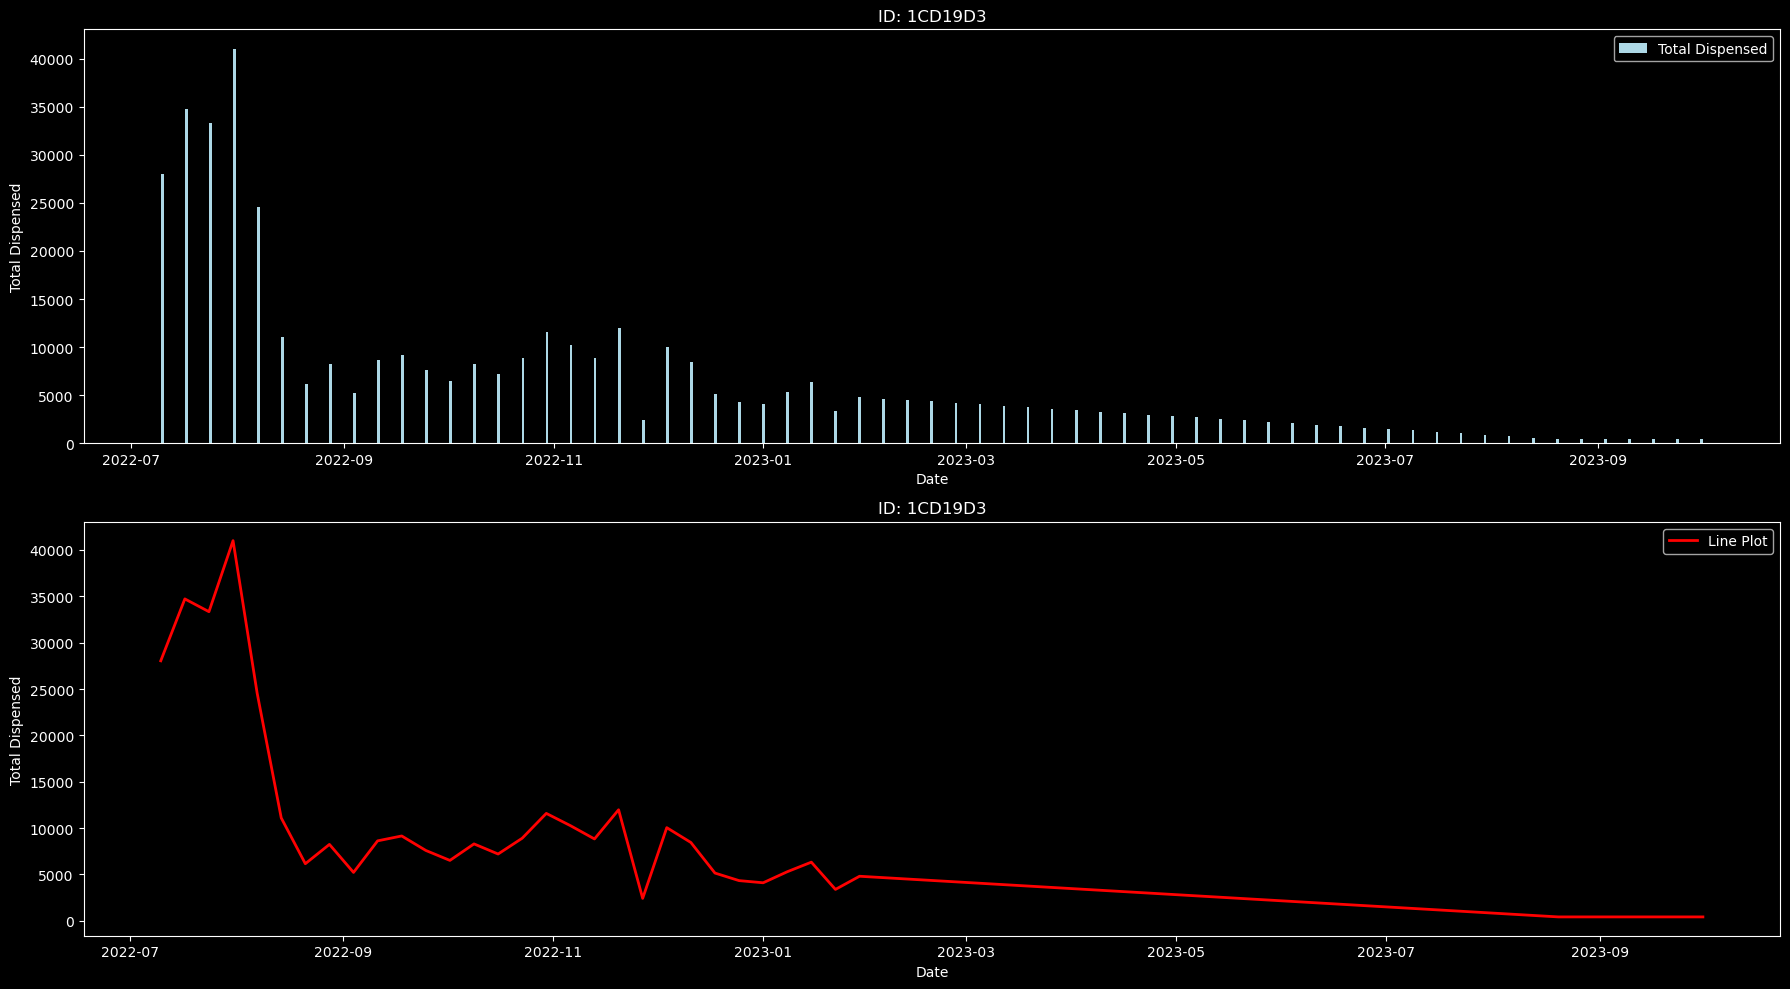

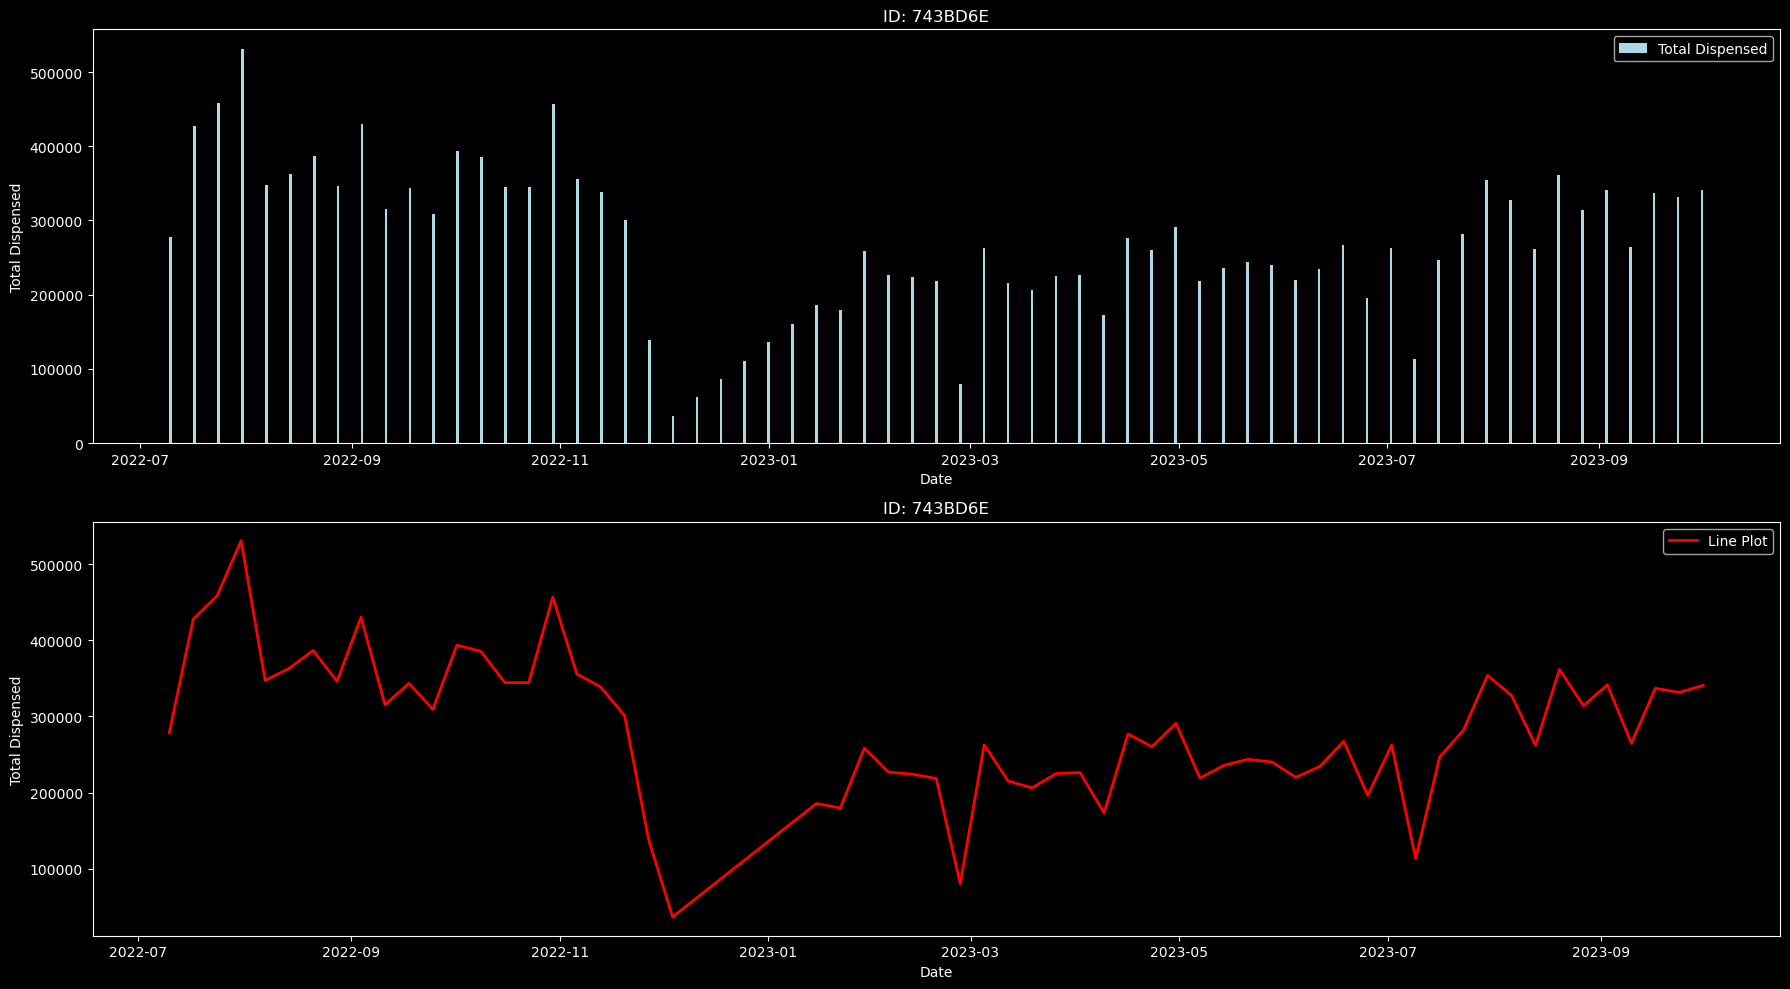

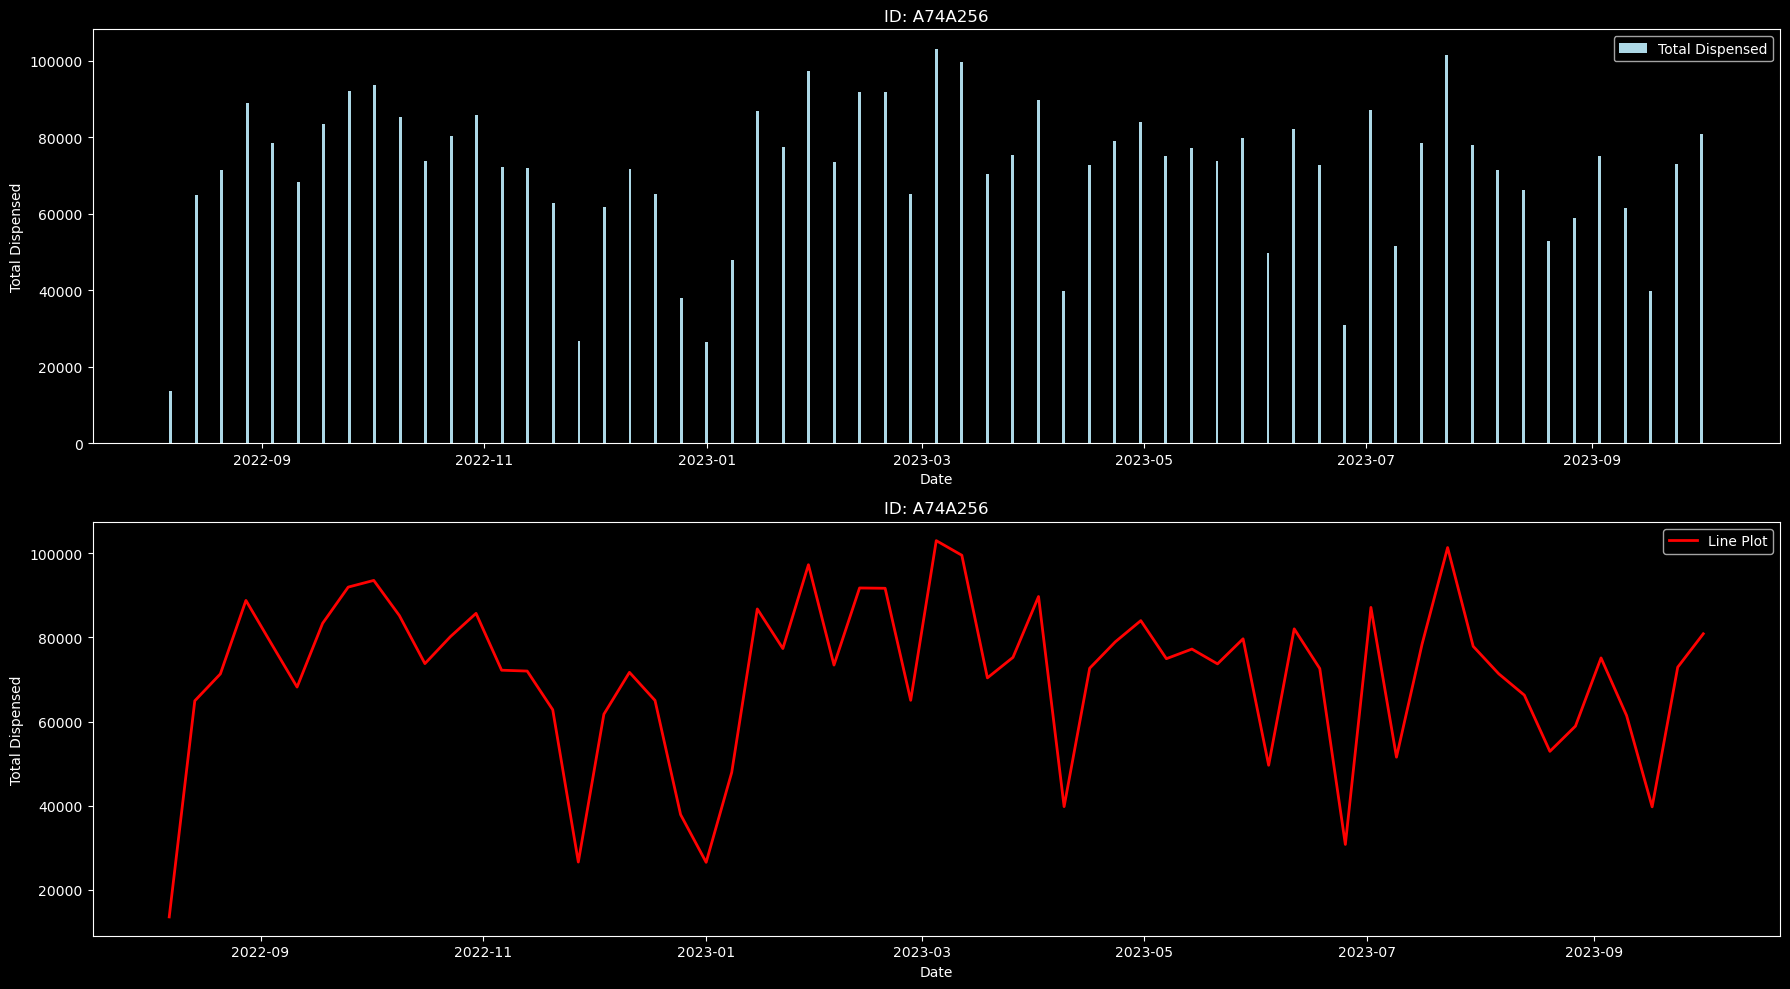

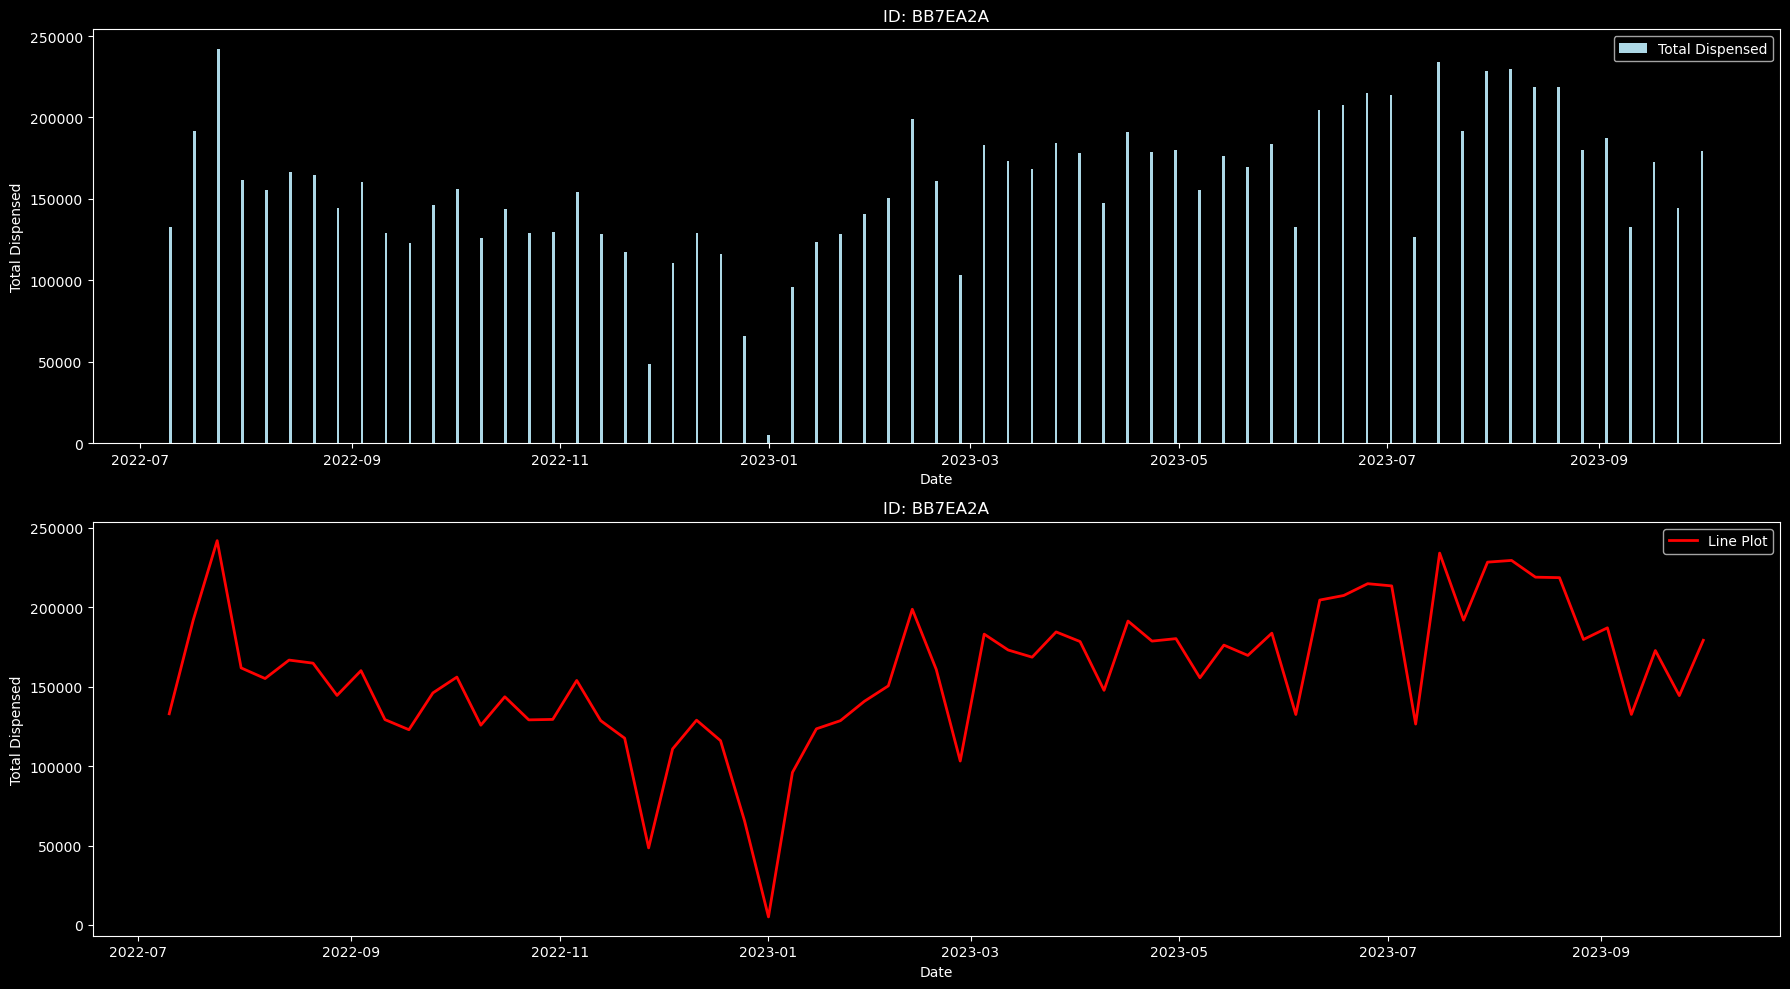

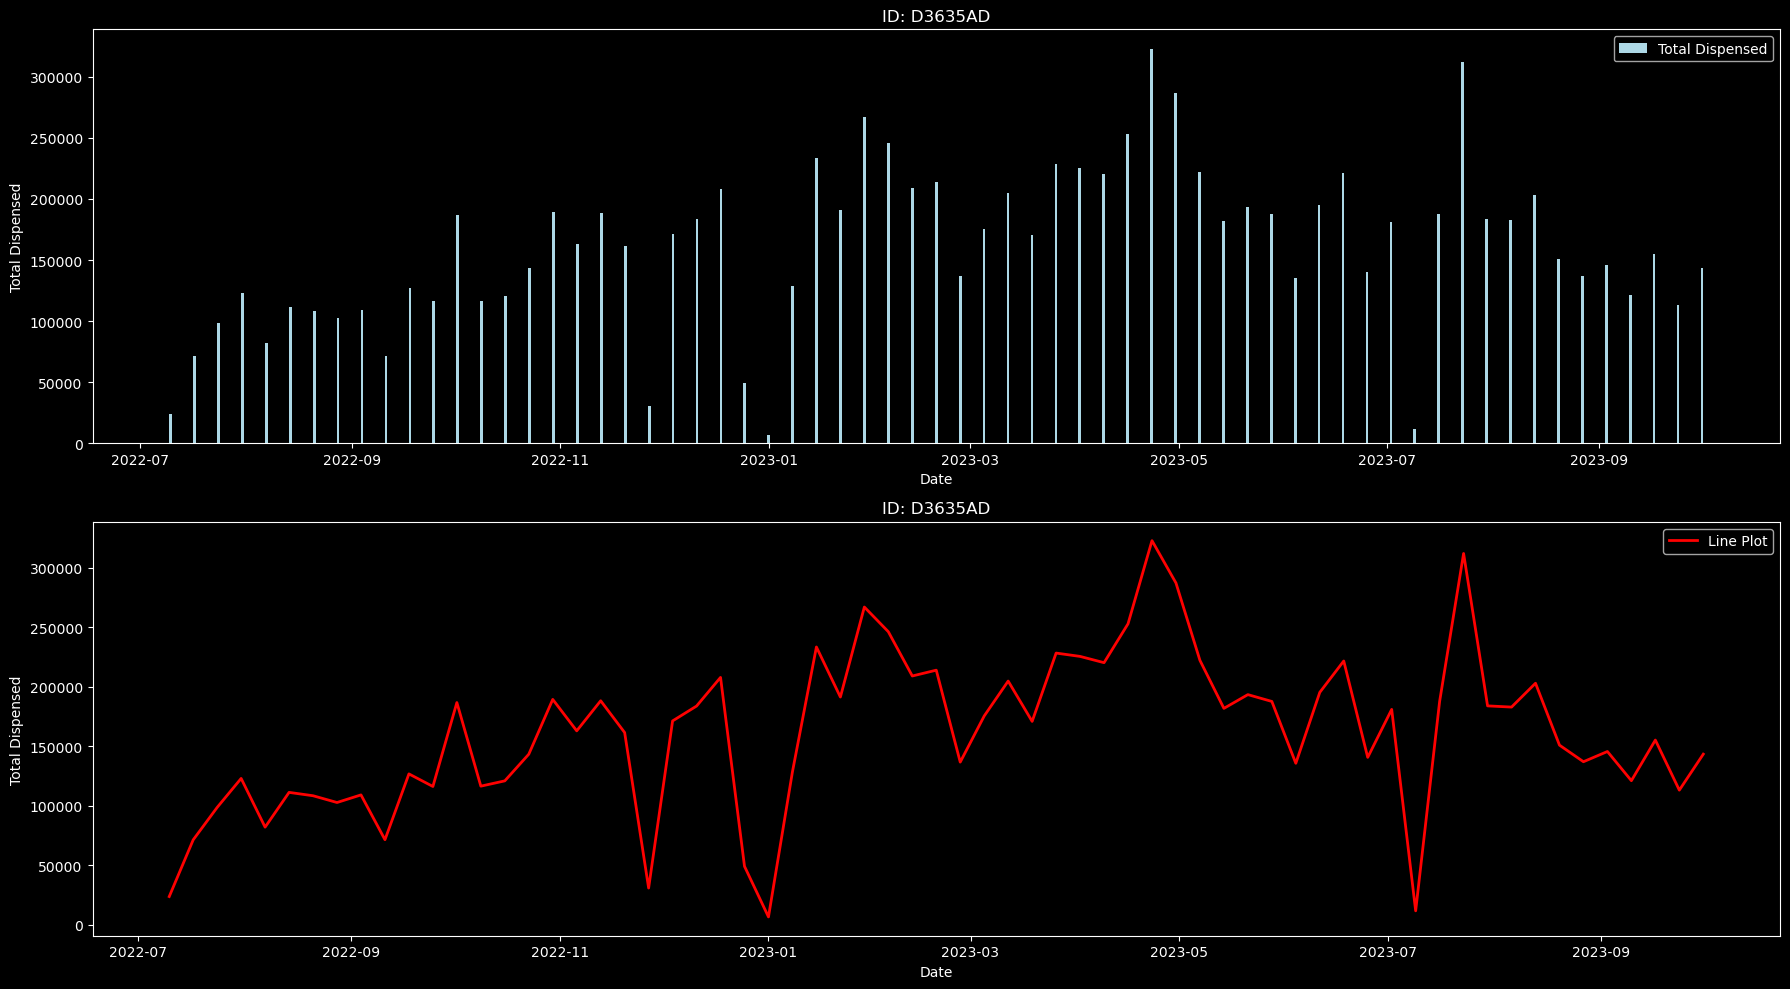

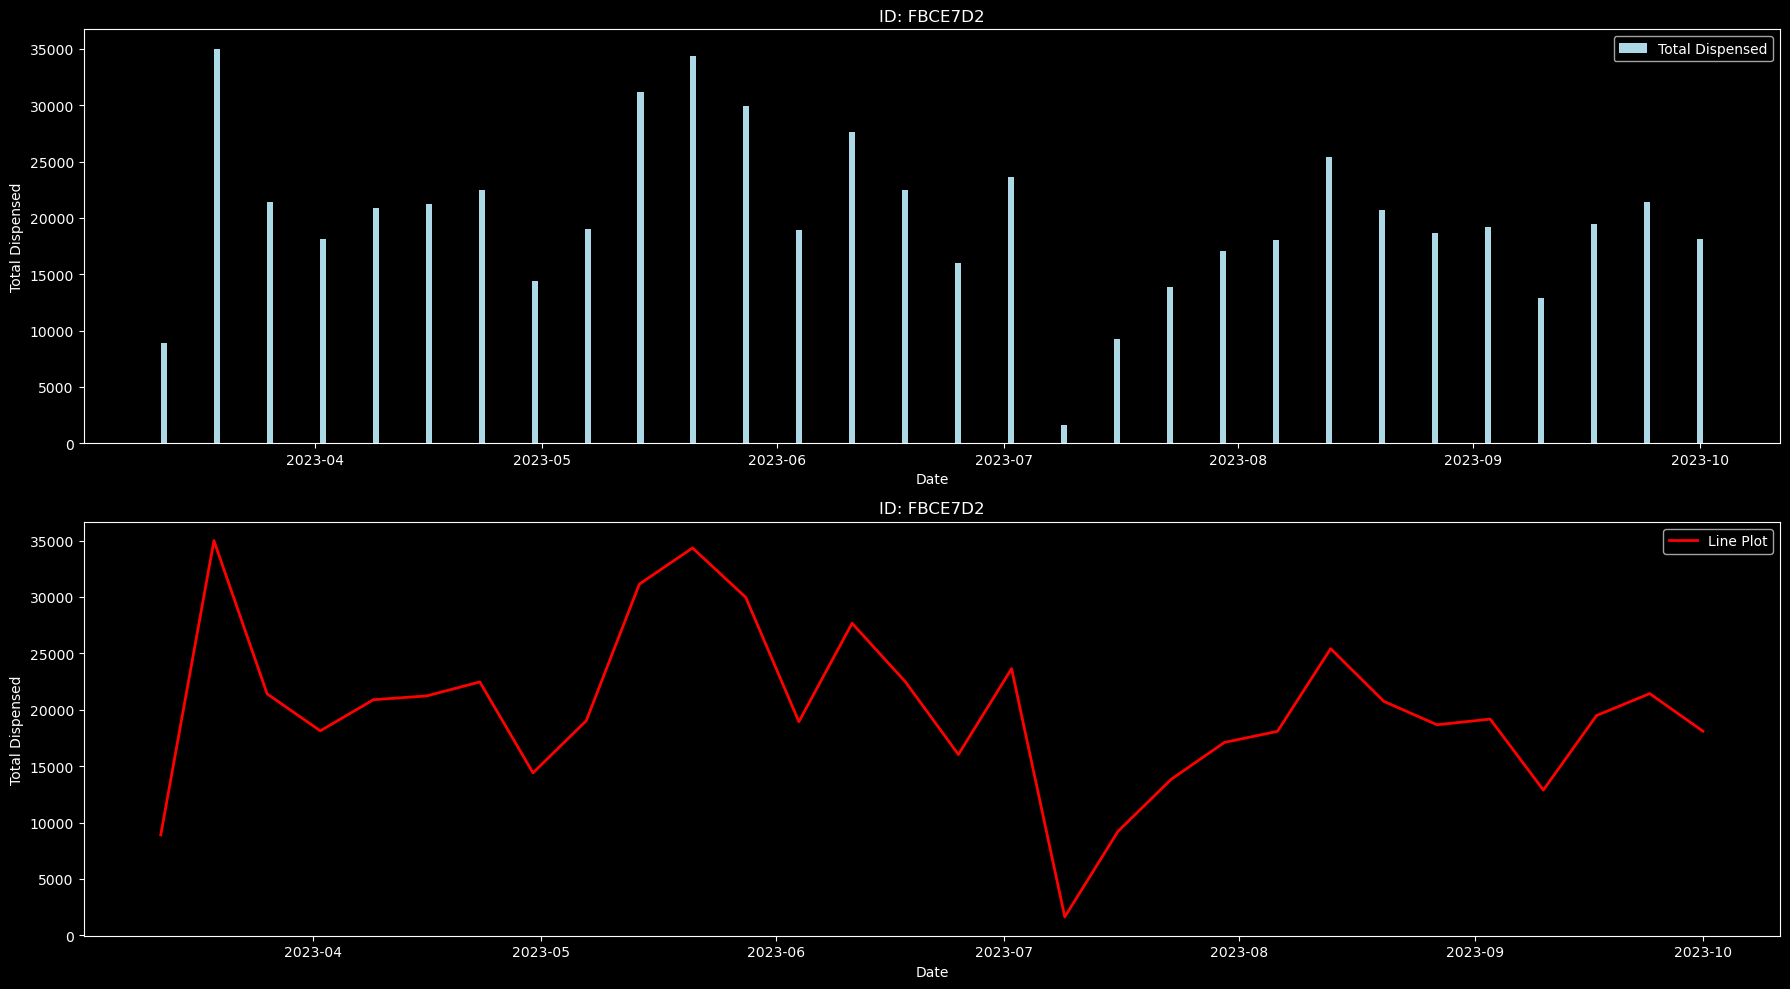

In [16]:
# Sort the data by 'ID' and then by 'WEEK_END_DT'
data_sorted = data.sort_values(by=['ID', 'WEEK_END_DT'])

# Group the sorted data by ID
grouped_data_sorted = data_sorted.groupby('ID')

# Set the figure size
plt.figure(figsize=(18, 10))

# Plot each group separately
for group_name, group_data in grouped_data_sorted:
    # Create subplots
    fig, axs = plt.subplots(2, figsize=(18, 10))

    # Plot bar plot
    axs[0].bar(group_data['WEEK_END_DT'], group_data['TOTAL_DISPENSED'], label='Total Dispensed', color='lightblue')

    # Set title and labels
    axs[0].set_title(f'ID: {group_name}')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Total Dispensed')

    # Sort the data by date for a continuous line plot
    sorted_data = group_data.sort_values(by='WEEK_END_DT')

    # Plot line plot
    axs[1].plot(sorted_data['WEEK_END_DT'], sorted_data['TOTAL_DISPENSED'], color='red', linewidth=2, label='Line Plot')

    # Set title and labels
    axs[1].set_title(f'ID: {group_name}')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('Total Dispensed')

    # Add legend
    axs[0].legend()
    axs[1].legend()

    # Show plot
    plt.tight_layout()
    plt.show()


In the first machine as there were more values missing we used seasonal interpolation to get that machine to maintain it's integrity and avoid biases, and the result looks good for now.

- Based on observing all the plots of each machine this data seems to be stationary.

Now we are checking whether there are any null values in the dataset based with Machine

In [21]:
zero_counts = data[data['TOTAL_DISPENSED'] == 0].groupby('ID').size()
distinct_zero_counts = zero_counts[zero_counts > 0].reset_index()
distinct_zero_counts.columns = ['ID', 'TOTAL_DISPENSED_zero_count']

zero_counts = data[data['FLAVORED_DISPENSED'] == 0].groupby('ID').size()
distinct_zero_counts['FLAVORED_DISPENSED_zero_count'] = zero_counts[zero_counts > 0].reset_index()[0]

distinct_zero_counts

,ID,TOTAL_DISPENSED_zero_count,FLAVORED_DISPENSED_zero_count


- We will now do feature engineering by extract various date-related features from the 'WEEK_END_DT' column, such as year, month, week, and day of the week. These features help capture seasonality and time-based patterns in the data.
- The data is sorted by 'ID' and 'WEEK_END_DT' within each 'ID' group to ensure that the lagged features are created in a time-ordered sequence for each machine.
- We create lagged features for the target variable 'TOTAL_DISPENSED' to include information about the previous weeks' dispensed values. These lagged features are essential for time series forecasting models as they provide historical context.

In [54]:
# Extract date features
data['year'] = data['WEEK_END_DT'].dt.year
data['month'] = data['WEEK_END_DT'].dt.month
data['week'] = data['WEEK_END_DT'].dt.isocalendar().week
data['dayofweek'] = data['WEEK_END_DT'].dt.dayofweek

In [59]:
# Sort the data by 'ID' and then by 'WEEK_END_DT' within each 'ID' group
data = data.sort_values(by=['ID', 'WEEK_END_DT'])

# Create lagged features for the target variable (TOTAL_DISPENSED)
for lag in range(1, 4):
    data[f'TOTAL_DISPENSED_lag_{lag}'] = data.groupby('ID')['TOTAL_DISPENSED'].shift(lag)

# Display the updated DataFrame with new features
print(data.head())

        ID WEEK_END_DT  TOTAL_DISPENSED  FLAVORED_DISPENSED  year  month  \
0  1CD19D3  2022-07-10         0.052077            0.065039  2022      7   
1  1CD19D3  2022-07-17         0.064665            0.074534  2022      7   
2  1CD19D3  2022-07-24         0.062067            0.085337  2022      7   
3  1CD19D3  2022-07-31         0.076513            0.106685  2022      7   
4  1CD19D3  2022-08-07         0.045510            0.040035  2022      8   

   week  dayofweek  TOTAL_DISPENSED_lag_1  TOTAL_DISPENSED_lag_2  \
0    27          6                    NaN                    NaN   
1    28          6               0.052077                    NaN   
2    29          6               0.064665               0.052077   
3    30          6               0.062067               0.064665   
4    31          6               0.076513               0.062067   

   TOTAL_DISPENSED_lag_3  
0                    NaN  
1                    NaN  
2                    NaN  
3               0.052077  

In [61]:
# Drop rows with NaN values
data.isna().sum()

ID                        0
WEEK_END_DT               0
TOTAL_DISPENSED           4
FLAVORED_DISPENSED        5
year                      0
month                     0
week                      0
dayofweek                 0
TOTAL_DISPENSED_lag_1    10
TOTAL_DISPENSED_lag_2    16
TOTAL_DISPENSED_lag_3    22
dtype: int64

In [62]:
data['TOTAL_DISPENSED'] = data['TOTAL_DISPENSED'].fillna(data.groupby('ID')['TOTAL_DISPENSED'].transform('mean'))
data['FLAVORED_DISPENSED'] = data['FLAVORED_DISPENSED'].fillna(data.groupby('ID')['FLAVORED_DISPENSED'].transform('mean'))
data['TOTAL_DISPENSED_lag_1'] = data['TOTAL_DISPENSED_lag_1'].fillna(data.groupby('ID')['TOTAL_DISPENSED_lag_1'].transform('mean'))
data['TOTAL_DISPENSED_lag_2'] = data['TOTAL_DISPENSED_lag_2'].fillna(data.groupby('ID')['TOTAL_DISPENSED_lag_2'].transform('mean'))
data['TOTAL_DISPENSED_lag_3'] = data['TOTAL_DISPENSED_lag_3'].fillna(data.groupby('ID')['TOTAL_DISPENSED_lag_3'].transform('mean'))

In [64]:
data.isna().sum()

ID                       0
WEEK_END_DT              0
TOTAL_DISPENSED          0
FLAVORED_DISPENSED       0
year                     0
month                    0
week                     0
dayofweek                0
TOTAL_DISPENSED_lag_1    0
TOTAL_DISPENSED_lag_2    0
TOTAL_DISPENSED_lag_3    0
dtype: int64

We split the data into training and testing sets based on the 'WEEK_END_DT' date. The training set includes data up to June 30, 2023.

The testing set includes data from July 2023 to September 2023. This set is used to evaluate the model's performance on new, unseen data. The model's predictions will be compared against the actual values in this set to assess accuracy.


In [65]:
# Filter data for training and testing sets
train_data = data[data['WEEK_END_DT'] <= '2023-06-30']
test_data = data[(data['WEEK_END_DT'] > '2023-06-30') & (data['WEEK_END_DT'] <= '2023-09-30')]

# Confirm the number of records in each set
print("Training set size:", len(train_data))
print("Testing set size:", len(test_data))


Training set size: 271
Testing set size: 78


We extract the features (year, month, week, dayofweek) and the target variable (TOTAL_DISPENSED) for both the training and testing datasets. This separation is crucial for supervised learning, where the model learns the relationship between the input features and the target variable.

These predictions are then compared to the actual values in the testing set to evaluate the model's performance.

In [66]:


# Separate features and target variable for training data
X_train = train_data[['year', 'month', 'week', 'dayofweek']]
y_train = train_data['TOTAL_DISPENSED']  

# Separate features and target variable for testing data
X_test = test_data[['year', 'month', 'week', 'dayofweek']]
y_test = test_data['TOTAL_DISPENSED']

# Initialize the linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Predict on the testing data
y_pred = model.predict(X_test)

# Evaluate the model
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
test_r2 = r2_score(y_test, y_pred)

print("Testing RMSE:", test_rmse)
print("Testing R^2 Score:", test_r2)


Testing RMSE: 0.21608851756258965
Testing R^2 Score: -0.07252210450516428


/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:605: Future

Based on the analysis, the initial linear regression model performed poorly, with a Testing RMSE of 0.216 and an R² Score of -0.073, indicating that it was not able to capture the underlying patterns in the data effectively. So let's try a complex model like Neural Networks (Multi layer preceptron).

In [70]:
# Convert input and output data to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


# Define the MLP model architecture
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model on testing data
y_test_pred = model.predict(X_test)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_r2 = r2_score(y_test, y_test_pred)

print("Testing RMSE:", test_rmse)
print("Testing R^2 Score:", test_r2)


Epoch 1/50
9/9 [==============================] - 0s 13ms/step - loss: 7474.4932 - val_loss: 1732.7275
Epoch 2/50
9/9 [==============================] - 0s 4ms/step - loss: 3472.1687 - val_loss: 750.4111
Epoch 3/50
9/9 [==============================] - 0s 4ms/step - loss: 1658.4740 - val_loss: 297.0564
Epoch 4/50
9/9 [==============================] - 0s 3ms/step - loss: 1072.6578 - val_loss: 172.2855
Epoch 5/50
9/9 [==============================] - 0s 29ms/step - loss: 793.8099 - val_loss: 76.8429
Epoch 6/50
9/9 [==============================] - 0s 8ms/step - loss: 675.6879 - val_loss: 29.5191
Epoch 7/50
9/9 [==============================] - 0s 5ms/step - loss: 523.4966 - val_loss: 17.9735
Epoch 8/50
9/9 [==============================] - 0s 3ms/step - loss: 554.1678 - val_loss: 10.3810
Epoch 9/50
9/9 [==============================] - 0s 3ms/step - loss: 287.1538 - val_loss: 4.6999
Epoch 10/50
9/9 [==============================] - 0s 2ms/step - loss: 358.9862 - val_loss: 1.3176


/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be remo

The Multilayer Perceptron (MLP) model was trained and evaluated on the dispense data. The model architecture consists of several dense layers with dropout regularization to prevent overfitting. The model was compiled using the Adam optimizer and mean squared error loss function. During training, the model was trained for 50 epochs with a batch size of 32. The training and validation loss decreased over the epochs, indicating learning. However, the model performance on the testing data was suboptimal, as indicated by a high RMSE value and negative R-squared score, suggesting that the model's predictions deviate significantly from the actual values. Further optimization or exploration of alternative models may be necessary to improve forecasting accuracy.

Let's stick this dataset for ARIMA, for that we should check for stationarity we will use adfuller to get test statistic and p-value

In [73]:
# Perform Augmented Dickey-Fuller test
result = adfuller(data['TOTAL_DISPENSED'])

# Print the test statistic and p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -3.727314002606402
p-value: 0.0037449558322281327


The Augmented Dickey-Fuller (ADF) test was conducted on the dispense data to assess its stationarity. The test resulted in an ADF statistic of -3.727 and a corresponding p-value of 0.0037. Since the p-value is less than the significance level of 0.05, we reject the null hypothesis, indicating that the data is stationary. Therefore, the dispense data exhibits stationarity, which is a prerequisite for time series modeling such as ARIMA.

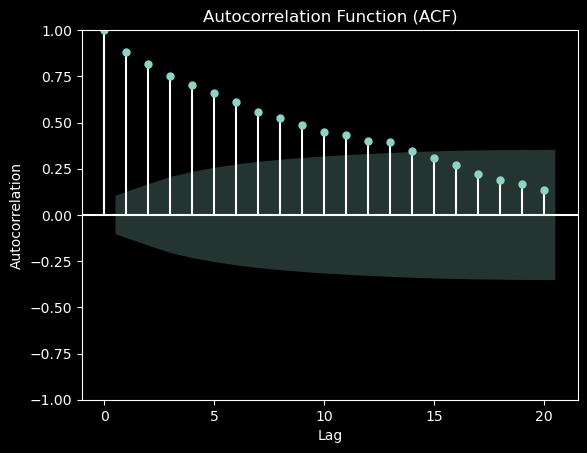

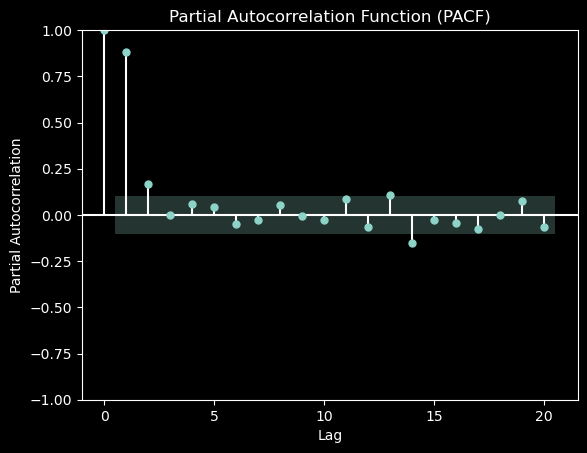

In [74]:
# Plot autocorrelation function (ACF)
plot_acf(data['TOTAL_DISPENSED'], lags=20)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot partial autocorrelation function (PACF)
plot_pacf(data['TOTAL_DISPENSED'], lags=20)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

ADF Statistic: -3.727314002606402
p-value: 0.0037449558322281327
Critical Values: {'1%': -3.4490114443793214, '5%': -2.8697627072503757, '10%': -2.5711506161673716}


/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be remo

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=174.881, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-656.598, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-149.396, Time=0.02 sec


/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be remo

 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-669.366, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-667.617, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-668.681, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-670.136, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-668.299, Time=0.05 sec


/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be remo

 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-326.097, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-669.301, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-675.568, Time=0.06 sec


/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be remo

 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-374.292, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-666.632, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-673.586, Time=0.34 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-673.575, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-123.926, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-500.762, Time=0.05 sec


/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be remo

 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-675.578, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-673.583, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-671.591, Time=0.09 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 1.652 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  355
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 341.789
Date:                Wed, 29 May 2024   AIC                           -675.578
Time:                        00:10:56   BIC                           -660.090
Sample:                             0   HQIC                          -669.416
                                - 355                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------

/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be remo

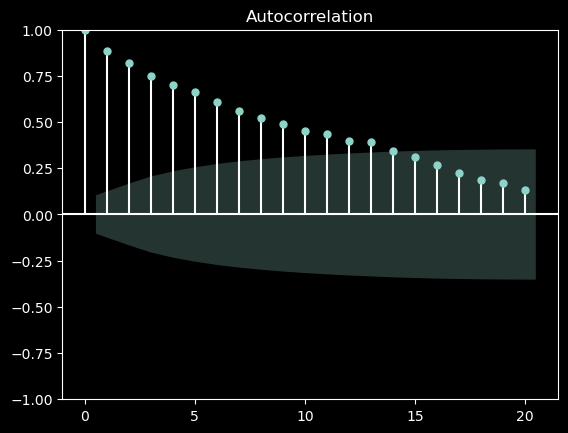

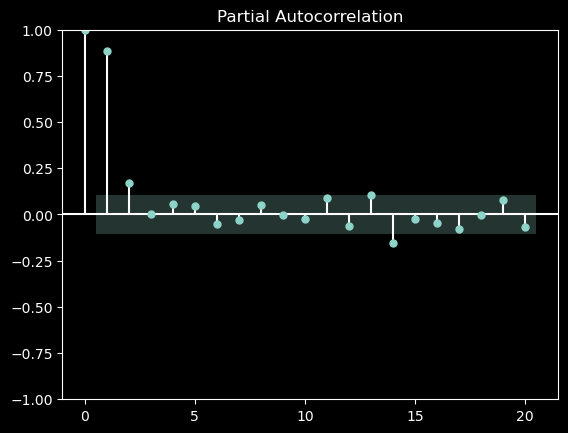

In [75]:

# Function to find the optimal ARIMA parameters
def find_arima_parameters(data):
    # Check stationarity using the Augmented Dickey-Fuller test
    adf_result = adfuller(data)
    print("ADF Statistic:", adf_result[0])
    print("p-value:", adf_result[1])
    print("Critical Values:", adf_result[4])
    
    # Plot ACF and PACF
    plot_acf(data, lags=20)
    plot_pacf(data, lags=20)
    
    # Find optimal ARIMA parameters based on ACF and PACF
    from pmdarima import auto_arima
    arima_model = auto_arima(data, start_p=0, start_q=0, max_p=3, max_q=3, seasonal=False, d=None, trace=True)
    print(arima_model.summary())

# Call the function with your time series data
find_arima_parameters(data['TOTAL_DISPENSED'])


The ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots are crucial tools for determining the appropriate parameters (p, d, q) for the ARIMA model. In the ACF plot, we observe the autocorrelation between an observation and its lagged values, with significant spikes indicating the strength of this correlation at various lags. A gradual decay in autocorrelation suggests the necessity for differencing (d parameter). Meanwhile, the PACF plot displays the direct relationship between an observation and its lagged values, removing the indirect effect of shorter lags. Significant spikes beyond the confidence interval in the PACF plot indicate the optimal value of the AR component (p parameter). In our analysis, we observed a gradual decay in the ACF plot, suggesting no need for differencing. The PACF plot exhibited significant spikes at lag 1 and 2, indicating that the AR component's order should be around 2 (p=2). This interpretation guides our selection of parameters for the ARIMA model.

So we got best model parameters (2, 0, 0). Now let's try to fit the model and plot the predicted values

                               SARIMAX Results                                
Dep. Variable:        TOTAL_DISPENSED   No. Observations:                  355
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 341.789
Date:                Wed, 29 May 2024   AIC                           -675.578
Time:                        01:58:55   BIC                           -660.090
Sample:                             0   HQIC                          -669.416
                                - 355                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2218      0.064      3.452      0.001       0.096       0.348
ar.L1          0.7320      0.029     25.221      0.000       0.675       0.789
ar.L2          0.1742      0.031      5.548      0.0

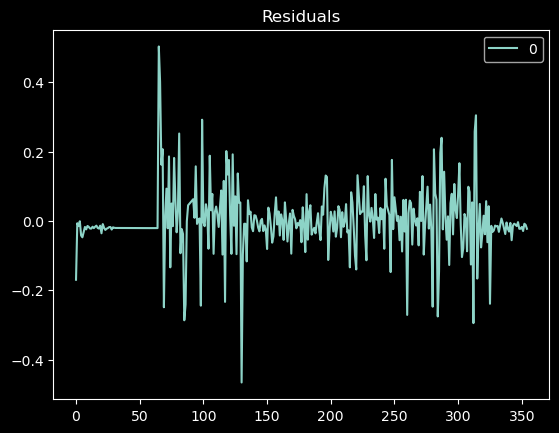

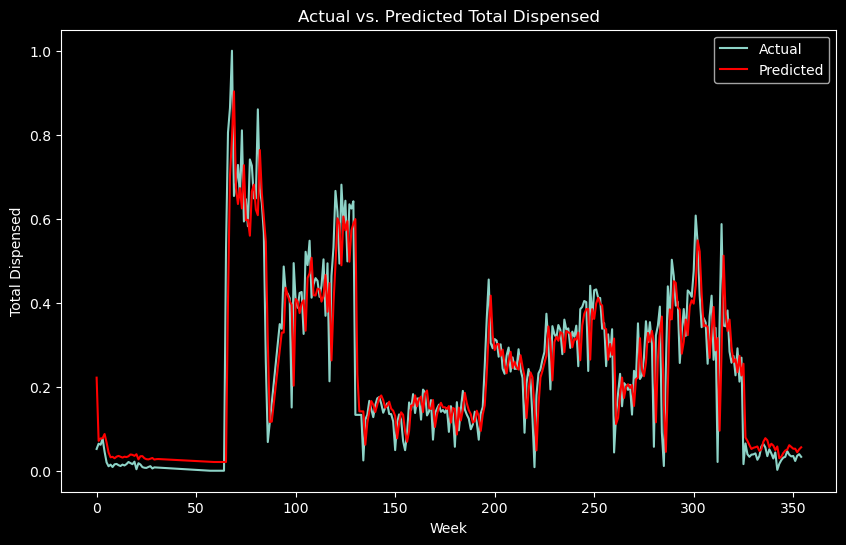

In [84]:

# Define the ARIMA model
model = ARIMA(data['TOTAL_DISPENSED'], order=(2,0,0)) # You can adjust the order as needed

# Fit the model
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(title='Residuals')
plt.show()

# Plot the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['TOTAL_DISPENSED'], label='Actual')
plt.plot(data.index, model_fit.fittedvalues, color='red', label='Predicted')
plt.title('Actual vs. Predicted Total Dispensed')
plt.xlabel('Week')
plt.ylabel('Total Dispensed')
plt.legend()
plt.show()


The ARIMA model with order (2, 0, 0) was fitted to the total dispensed data. The model's summary provides insights into the coefficients of the model, including the constant term and autoregressive parameters. The coefficient estimates are statistically significant (p < 0.05), indicating a strong relationship between the observed and lagged values. The residuals plot shows that the model captures most of the variation in the data, with no discernible patterns remaining in the residuals. The actual vs. predicted plot illustrates that the model closely follows the observed data, indicating a good fit.

Now let's evaluate by testing with the test dataset

In [86]:
# Forecast for the weeks in July to November
forecast_start_date = '2023-07-01'
forecast_end_date = '2023-11-30'
n_forecast_steps = (pd.to_datetime(forecast_end_date) - pd.to_datetime(forecast_start_date)).days // 7 + 1

# Forecast
forecast = model_fit.forecast(steps=n_forecast_steps)

# Convert forecast to DataFrame
forecast_dates = pd.date_range(start=forecast_start_date, periods=n_forecast_steps, freq='W')
forecast_df = pd.DataFrame({'WEEK_END_DT': forecast_dates, 'TOTAL_DISPENSED_forecast': forecast})

# Merge actual and forecasted values based on the common column (e.g., 'WEEK_END_DT')

evaluation_df = data.merge(forecast_df, on='WEEK_END_DT', how='inner')

# Display forecast
print(forecast_df)


    WEEK_END_DT  TOTAL_DISPENSED_forecast
355  2023-07-02                  0.052100
356  2023-07-09                  0.064752
357  2023-07-16                  0.077283
358  2023-07-23                  0.088660
359  2023-07-30                  0.099170
360  2023-08-06                  0.108845
361  2023-08-13                  0.117759
362  2023-08-20                  0.125968
363  2023-08-27                  0.133530
364  2023-09-03                  0.140496
365  2023-09-10                  0.146911
366  2023-09-17                  0.152821
367  2023-09-24                  0.158265
368  2023-10-01                  0.163279
369  2023-10-08                  0.167897
370  2023-10-15                  0.172151
371  2023-10-22                  0.176069
372  2023-10-29                  0.179679
373  2023-11-05                  0.183003
374  2023-11-12                  0.186065
375  2023-11-19                  0.188886
376  2023-11-26                  0.191484


In [89]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(evaluation_df['TOTAL_DISPENSED'], evaluation_df['TOTAL_DISPENSED_forecast'])

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(evaluation_df['TOTAL_DISPENSED'], evaluation_df['TOTAL_DISPENSED_forecast'])

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)


Mean Absolute Error (MAE): 0.18541536923328628
Mean Squared Error (MSE): 0.05736884949727003
Root Mean Squared Error (RMSE): 0.23951795234860795


/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be remo

In [90]:
# Define the start and end date for the forecast
forecast_start_date = '2023-07-01'
forecast_end_date = '2023-11-30'

# Calculate the number of weeks to forecast
n_forecast_steps = (pd.to_datetime(forecast_end_date) - pd.to_datetime(forecast_start_date)).days // 7 + 1

# Forecast for the defined period
forecast = model_fit.forecast(steps=n_forecast_steps)

# Convert forecast to DataFrame
forecast_dates = pd.date_range(start=forecast_start_date, periods=n_forecast_steps, freq='W')
forecast_df = pd.DataFrame({'WEEK_END_DT': forecast_dates, 'FORECAST_TOTAL_DISPENSED': forecast})
print(forecast_df)

    WEEK_END_DT  FORECAST_TOTAL_DISPENSED
355  2023-07-02                  0.052100
356  2023-07-09                  0.064752
357  2023-07-16                  0.077283
358  2023-07-23                  0.088660
359  2023-07-30                  0.099170
360  2023-08-06                  0.108845
361  2023-08-13                  0.117759
362  2023-08-20                  0.125968
363  2023-08-27                  0.133530
364  2023-09-03                  0.140496
365  2023-09-10                  0.146911
366  2023-09-17                  0.152821
367  2023-09-24                  0.158265
368  2023-10-01                  0.163279
369  2023-10-08                  0.167897
370  2023-10-15                  0.172151
371  2023-10-22                  0.176069
372  2023-10-29                  0.179679
373  2023-11-05                  0.183003
374  2023-11-12                  0.186065
375  2023-11-19                  0.188886
376  2023-11-26                  0.191484


In [91]:
# Function to fit ARIMA and forecast for each machine
def forecast_machine(machine_id, data, forecast_start_date, forecast_end_date):
    # Filter data for the machine
    machine_data = data[data['ID'] == machine_id]
    
    # Fit the ARIMA model
    model = ARIMA(machine_data['TOTAL_DISPENSED'], order=(2, 0, 0))
    results = model.fit()
    
    # Calculate the number of weeks to forecast
    n_forecast_steps = (pd.to_datetime(forecast_end_date) - pd.to_datetime(forecast_start_date)).days // 7 + 1
    
    # Forecast
    forecast = results.forecast(steps=n_forecast_steps)
    
    # Convert forecast to DataFrame
    forecast_dates = pd.date_range(start=forecast_start_date, periods=n_forecast_steps, freq='W')
    forecast_df = pd.DataFrame({'ID': machine_id, 'WEEK_END_DT': forecast_dates, 'FORECAST_TOTAL_DISPENSED': forecast})
    
    return forecast_df

# List of unique machine IDs
machine_ids = data['ID'].unique()

# Define forecast period
forecast_start_date = '2023-07-01'
forecast_end_date = '2023-11-30'

# Generate forecasts for each machine
forecasts = [forecast_machine(machine_id, data, forecast_start_date, forecast_end_date) for machine_id in machine_ids]

# Combine all forecasts
all_forecasts_df = pd.concat(forecasts)
print(all_forecasts_df)


         ID WEEK_END_DT  FORECAST_TOTAL_DISPENSED
65  1CD19D3  2023-07-02                  0.001395
66  1CD19D3  2023-07-09                  0.002490
67  1CD19D3  2023-07-16                  0.003504
68  1CD19D3  2023-07-23                  0.004436
69  1CD19D3  2023-07-30                  0.005295
..      ...         ...                       ...
47  FBCE7D2  2023-10-29                  0.036775
48  FBCE7D2  2023-11-05                  0.036775
49  FBCE7D2  2023-11-12                  0.036775
50  FBCE7D2  2023-11-19                  0.036775
51  FBCE7D2  2023-11-26                  0.036775

[132 rows x 3 columns]


/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/sibivishtan/a

In [92]:
# Function to fit ARIMA and forecast for flavored water dispensed
def forecast_flavored(machine_id, data, forecast_start_date, forecast_end_date):
    # Filter data for the machine
    machine_data = data[data['ID'] == machine_id]
    
    # Fit the ARIMA model
    model = ARIMA(machine_data['FLAVORED_DISPENSED'], order=(2, 0, 0))
    results = model.fit()
    
    # Calculate the number of weeks to forecast
    n_forecast_steps = (pd.to_datetime(forecast_end_date) - pd.to_datetime(forecast_start_date)).days // 7 + 1
    
    # Forecast
    forecast = results.forecast(steps=n_forecast_steps)
    
    # Convert forecast to DataFrame
    forecast_dates = pd.date_range(start=forecast_start_date, periods=n_forecast_steps, freq='W')
    forecast_df = pd.DataFrame({'ID': machine_id, 'WEEK_END_DT': forecast_dates, 'FORECAST_FLAVORED_DISPENSED': forecast})
    
    return forecast_df

# Generate forecasts for flavored water for each machine
flavored_forecasts = [forecast_flavored(machine_id, data, forecast_start_date, forecast_end_date) for machine_id in machine_ids]

# Combine all forecasts
all_flavored_forecasts_df = pd.concat(flavored_forecasts)
print(all_flavored_forecasts_df)


         ID WEEK_END_DT  FORECAST_FLAVORED_DISPENSED
65  1CD19D3  2023-07-02                     0.002567
66  1CD19D3  2023-07-09                     0.004030
67  1CD19D3  2023-07-16                     0.005360
68  1CD19D3  2023-07-23                     0.006563
69  1CD19D3  2023-07-30                     0.007651
..      ...         ...                          ...
47  FBCE7D2  2023-10-29                     0.032269
48  FBCE7D2  2023-11-05                     0.032269
49  FBCE7D2  2023-11-12                     0.032269
50  FBCE7D2  2023-11-19                     0.032269
51  FBCE7D2  2023-11-26                     0.032269

[132 rows x 3 columns]


/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/sibivishtan/a

In [93]:
def evaluate_model(machine_id, data, forecast_df):
    # Filter actual data for the machine and testing period
    test_data = data[(data['ID'] == machine_id) & (data['WEEK_END_DT'] >= '2023-07-01') & (data['WEEK_END_DT'] <= '2023-09-30')]
    
    # Filter forecast data for the machine and testing period
    forecast_data = forecast_df[(forecast_df['ID'] == machine_id) & (forecast_df['WEEK_END_DT'] >= '2023-07-01') & (forecast_df['WEEK_END_DT'] <= '2023-09-30')]
    
    # Merge the actual and forecast data on WEEK_END_DT
    merged_data = test_data.merge(forecast_data, on='WEEK_END_DT', how='inner')
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(merged_data['TOTAL_DISPENSED'], merged_data['FORECAST_TOTAL_DISPENSED'])
    mse = mean_squared_error(merged_data['TOTAL_DISPENSED'], merged_data['FORECAST_TOTAL_DISPENSED'])
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse

# Evaluate model for each machine
evaluation_results = {}
for machine_id in machine_ids:
    mae, mse, rmse = evaluate_model(machine_id, data, all_forecasts_df)
    evaluation_results[machine_id] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse}

# Display evaluation results
for machine_id, metrics in evaluation_results.items():
    print(f"Machine ID: {machine_id} - MAE: {metrics['MAE']}, MSE: {metrics['MSE']}, RMSE: {metrics['RMSE']}")

Machine ID: 1CD19D3 - MAE: 0.00574911518093082, MSE: 4.2753637546497185e-05, RMSE: 0.006538626579527017
Machine ID: 743BD6E - MAE: 0.10651214985926415, MSE: 0.018941576039902507, RMSE: 0.13762839837730623
Machine ID: A74A256 - MAE: 0.023265771765176198, MSE: 0.000878515752582839, RMSE: 0.029639766405672615
Machine ID: BB7EA2A - MAE: 0.07954646976517782, MSE: 0.00783310053912827, RMSE: 0.0885048051753591
Machine ID: D3635AD - MAE: 0.08455973686124674, MSE: 0.014654728673044246, RMSE: 0.12105671676137696
Machine ID: FBCE7D2 - MAE: 0.008822236147917165, MSE: 0.00016165499606740302, RMSE: 0.012714361803386084


/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be remo

In [94]:
# Function to evaluate flavored water forecast
def evaluate_flavored_model(machine_id, data, forecast_df):
    # Filter actual data for the machine and testing period
    test_data = data[(data['ID'] == machine_id) & (data['WEEK_END_DT'] >= '2023-07-01') & (data['WEEK_END_DT'] <= '2023-09-30')]
    
    # Filter forecast data for the machine and testing period
    forecast_data = forecast_df[(forecast_df['ID'] == machine_id) & (forecast_df['WEEK_END_DT'] >= '2023-07-01') & (forecast_df['WEEK_END_DT'] <= '2023-09-30')]
    
    # Merge the actual and forecast data on WEEK_END_DT
    merged_data = test_data.merge(forecast_data, on='WEEK_END_DT', how='inner')
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(merged_data['FLAVORED_DISPENSED'], merged_data['FORECAST_FLAVORED_DISPENSED'])
    mse = mean_squared_error(merged_data['FLAVORED_DISPENSED'], merged_data['FORECAST_FLAVORED_DISPENSED'])
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse

# Evaluate flavored water model for each machine
flavored_evaluation_results = {}
for machine_id in machine_ids:
    mae, mse, rmse = evaluate_flavored_model(machine_id, data, all_flavored_forecasts_df)
    flavored_evaluation_results[machine_id] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse}

# Display evaluation results
for machine_id, metrics in flavored_evaluation_results.items():
    print(f"Machine ID: {machine_id} - MAE: {metrics['MAE']}, MSE: {metrics['MSE']}, RMSE: {metrics['RMSE']}")


Machine ID: 1CD19D3 - MAE: 0.007619593904487274, MSE: 7.308364053222664e-05, RMSE: 0.008548897036005677
Machine ID: 743BD6E - MAE: 0.18771832317350554, MSE: 0.04440310466555461, RMSE: 0.21072044197361253
Machine ID: A74A256 - MAE: 0.038128345101128905, MSE: 0.0021700862272833786, RMSE: 0.0465841843041539
Machine ID: BB7EA2A - MAE: 0.09298003554081466, MSE: 0.010840693377438175, RMSE: 0.10411865047837575
Machine ID: D3635AD - MAE: 0.18775126192930255, MSE: 0.0528685009555871, RMSE: 0.22993151362000622
Machine ID: FBCE7D2 - MAE: 0.012418240526421043, MSE: 0.00023550749995581387, RMSE: 0.015346253613042302


/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be remo